In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm

import gensim
from gensim.models import Word2Vec
from gensim.parsing.porter import PorterStemmer
from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.8/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
type_dict={'Backports': 'Backport', 
           
    'Blocked': 'Block',
    'Blocker': 'Block',
    'Blocks': 'Block',
           
    'Bonfire Testing': 'Bonfire Testing', 
    'Bonfire testing': 'Bonfire Testing', 
    'Git Code Review': 'Bonfire Testing', 
    'Testing': 'Bonfire Testing',
           
    'Causality': 'Cause', 
    'Cause': 'Cause',
    'Caused': 'Cause', 
    'Problem/Incident': 'Cause',
           
    'Child-Issue': 'Parent-Child', 
    'Parent Feature': 'Parent-Child',
    'Parent/Child': 'Parent-Child',
    'multi-level hierarchy [GANTT]': 'Parent-Child',
    'Parent-Relation': 'Parent-Child',
           
    'Cloners': 'Clone', 
    'Cloners (old)': 'Clone', 
           
    'Collection': 'Incorporate', 
    'Container': 'Incorporate',
    'Contains(WBSGantt)': 'Incorporate', 
    'Incorporate': 'Incorporate', 
    'Incorporates': 'Incorporate', 
    'Part': 'Incorporate',
    'PartOf': 'Incorporate',
    'Superset': 'Incorporate', 
           
    'Completes': 'Fix', 
    'Fixes': 'Fix',
    'Resolve': 'Fix',
           
    'Depend': 'Depend', 
    'Dependency': 'Depend', 
    'Dependent': 'Depend', 
    'Depends': 'Depend', 
    'Gantt Dependency': 'Depend',
    'dependent': 'Depend',
           
    'Derived': 'Derive',
           
    'Detail': 'Detail', 
           
    'Documentation': 'Documented',
    'Documented': 'Documented',
    
    'Duplicate': 'Duplicate',
           
    'Epic': 'Epic', 
    'Epic-Relation': 'Epic',
    
    'Finish-to-Finish link (WBSGantt)': 'finish-finish', 
    'Gantt End to End': 'finish-finish', 
    'Gantt: finish-finish': 'finish-finish',
    'finish-finish [GANTT]': 'finish-finish', 
    
    'Gantt End to Start': 'finish-start', 
    'Gantt: finish-start': 'finish-start',
    'finish-start [GANTT]': 'finish-start',

    'Gantt Start to Start': 'start-start', 
    
    'Gantt: start-finish': 'start-finish', 
    
    'Follows': 'Follow', 
    'Sequence': 'Follow', 
    
    'Implement': 'Implement', 
    'Implements': 'Implements', 
    
    'Issue split': 'Split',
    'Split': 'Split',
    'Work Breakdown': 'Split',
    
    'Preceded By': 'Precede', 
    
    'Reference': 'Relate',
    'Relate': 'Relate',
    'Related': 'Relate', 
    'Relates': 'Relate',
    'Relationship': 'Relate',
    
    'Regression': 'Breaks', 
    
    'Replacement': 'Replace',
    
    'Required': 'Require', 
    
    'Supercedes': 'Supercede',
    'Supersede': 'Supercede',
    'Supersession': 'Supercede', 
    
    'Subtask': 'Subtask',
    
    'Test': 'Test', 
    'Tested': 'Test',
    
    'Trigger': 'Trigger', 
    
    'Non-Link': 'Non-Link',
          
    '1 - Relate': 'Relate',
'Subtask': 'Subtask',
'5 - Depend':   'Depend',          
'3 - Duplicate': 'Duplicate',          
'4 - Incorporate': 'Incorporate',        
'2 - Cloned': 'Clone',               
'6 - Blocks': 'Block',                
'7 - Git Code Review': 'Bonfire Testing',
          'Verify': 'Verify'}

cat_dict = {'Block': 'Causal',
    'Bonfire Testing': 'Workflow',
    'Breaks': 'Causal',
    'Cause': 'Causal',
    'Clone': 'General',
    'Depend': 'Causal',
    'Detail': 'Workflow',
    'Documented': 'Workflow',
    'Duplicate': 'General',
    'Epic': 'Epic',
    'Fix': 'Workflow',
    'Follow': 'Causal',
    'Incorporate': 'Split',
    'Parent-Child': 'Split',
    'Relate': 'General',
    'Replace': 'General',
    'Require': 'Causal',
    'Split': 'Split',
    'Subtask': 'Split',
    'Supercede': 'Causal',
    'Trigger': 'Workflow',
    'finish-start': 'Causal',
    'Non-Link': 'Non-Link'
           }

In [3]:
def load_data(source):
    #Loading Issues
    filename = '../data/processed/issues_'+source.lower()+'.csv'
    issue_df = pd.read_csv(filename, encoding="UTF-8", low_memory=False, sep=';')

    #Loading Links
    filename = '../data/processed/links_'+source.lower()+'.csv'
    link_df = pd.read_csv(filename, encoding="UTF-8", low_memory=False, sep=';')
    
    return issue_df, link_df

In [4]:
SOURCES = ['Apache', 'Hyperledger', 'IntelDAOS', 'JFrog', 'Jira', 
           'JiraEcosystem', 'MariaDB', 'Mindville', 'Mojang', 'MongoDB', 
           'Qt', 'RedHat', 'Sakai', 'SecondLife', 'Sonatype', 'Spring']

In [5]:
link_dict = {}
issue_dict = {}

for s in SOURCES:
    print(s.upper())
    issues, links = load_data(s)
    link_dict[s] = links
    issue_dict[s] = issues


APACHE
HYPERLEDGER
INTELDAOS
JFROG
JIRA
JIRAECOSYSTEM
MARIADB
MINDVILLE
MOJANG
MONGODB
QT
REDHAT
SAKAI
SECONDLIFE
SONATYPE
SPRING


In [6]:
def print_linktypes(SOURCE):
    issues = issue_dict[SOURCE]
    links = link_dict[SOURCE]
    
    links['mappedtype'] = links['linktype'].map(type_dict)
    
    issue_set = set(issues['issue_id'])
        
    link_set = set(links['issue_id_1']).union(set(links['issue_id_2']))
        
    return len(issues), len(links), len(links.mappedtype.unique()), round(len(link_set)/len(issue_set), 3),  len(issues.projectid.unique())

In [7]:
overview = pd.DataFrame(columns = ['Project', '#Issues', '#Links', '#Linktypes', '%IssuesWithLinks', '#Projects'])
j=0
for s in SOURCES:
    i, l, ltu, pi, p = print_linktypes(s)
    
    overview.loc[j]=[s, i, l, ltu, pi, p]
    
    j+=1

In [8]:
overview.median()

#Issues             59853.000
#Links              15461.000
#Linktypes             10.500
%IssuesWithLinks        0.361
#Projects              24.000
dtype: float64

In [9]:
def print_linktypes_more(SOURCE):
    
    issues = issue_dict[SOURCE]
    links = link_dict[SOURCE]
    
    links['mappedtype'] = links['linktype'].map(type_dict)
        
    num_links = len(links)
    num_issues = len(issues)
    
    issue_set = set(issues.index.values)
    link_set = set(links['issue_id_1']).union(set(links['issue_id_2']))

    projects = issues[['projectid', 'issue_id']]
    
    temp = links.merge(projects, left_on='issue_id_1', right_on='issue_id')
    temp = temp.merge(projects, left_on='issue_id_2', right_on='issue_id', suffixes=('_1', '_2'))
    

    temp['sameproject'] = (temp["projectid_1"]==temp["projectid_2"])

    blub = temp.mappedtype.value_counts().rename_axis('mappedtype').reset_index(name='counts')
    try:
        same_ratio = round(temp['sameproject'].value_counts().loc[True]/len(temp)*100, 2)
    except:
        same_ratio = 0
    try:
        cross_ratio = round(temp['sameproject'].value_counts().loc[False]/len(temp)*100, 2)
    except:
        cross_ratio = 0

    blub = links.mappedtype.value_counts().rename_axis('mappedtype').reset_index(name='counts')
    blub['source'] = SOURCE
    blub['percentages'] = blub['counts'].apply(lambda x: round(x/len(links),3)*100)
    blub['sameproject'] = 0
    blub['crossproject'] = 0
    for i in temp.mappedtype.value_counts().index:
        link_temp = temp[temp['mappedtype'] == i]
        try:
            same_ratio_temp = round(link_temp['sameproject'].value_counts().loc[True]/len(link_temp)*100, 2)
        except:
            same_ratio_temp = 0
        try:
            cross_ratio_temp = round(link_temp['sameproject'].value_counts().loc[False]/len(link_temp)*100, 2)
        except:
            cross_ratio_temp = 0
        link_index = blub.index[blub['mappedtype']==i]
        link_index = list(link_index)
        blub['sameproject'].iloc[link_index[0]] = same_ratio_temp
        blub['crossproject'].iloc[link_index[0]] = cross_ratio_temp
        
    return num_issues, num_links, len(links.mappedtype.unique()), round(len(link_set)/len(issue_set), 3), len(link_set), same_ratio, cross_ratio, blub


In [10]:
overview2 = pd.DataFrame(columns = ['Source', '#Issues', '#Links', '#Linktypes', '%IssuesWithLinks', '#LinkedIssues', "%SameProject", "%CrossProject"])
link_dist = pd.DataFrame(columns=['source', 'linktype', 'counts'])
j = 0
for s in SOURCES:
    i, l, ltu, pi, li, sr, cr, blub = print_linktypes_more(s)
    overview2.loc[j] = [s, i, l, ltu, pi, li, sr, cr]
    
    j+=1
    
    frames = [link_dist, blub]
    #concatenate dataframes
    link_dist = pd.concat(frames, sort=False)

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [51]:
overview2

,Source,#Issues,#Links,#Linktypes,%IssuesWithLinks,#LinkedIssues,%SameProject,%CrossProject
0,Apache,1014926,255767,16,0.285,289589,94.77,5.23
1,Hyperledger,28146,16304,8,0.549,15457,95.38,4.62
2,IntelDAOS,9474,2599,11,0.308,2918,96.73,3.27
3,JFrog,15535,3229,10,0.286,4439,91.76,8.24
4,Jira,274545,99819,16,0.467,128336,56.58,43.42
5,JiraEcosystem,41866,11398,14,0.330,13804,93.23,6.77
6,MariaDB,31229,14618,8,0.445,13895,97.46,2.54
7,Mindville,2134,44,4,0.040,85,95.45,4.55
8,Mojang,420819,215527,5,0.537,225823,94.57,5.43
9,MongoDB,137172,63821,14,0.452,61950,80.91,19.09


In [50]:
overview2['%CrossProject'].values

array([ 5.23,  4.62,  3.27,  8.24, 43.42,  6.77,  2.54,  4.55,  5.43,
       19.09,  6.92, 23.54,  1.37,  2.38,  1.5 ,  9.96])

In [12]:
def print_cleaned_linktypes(SOURCE):  
    
    issues = issue_dict[SOURCE]
    links = link_dict[SOURCE]
    
    issue_set = set(issues.index.values)
    link_set = set(links['issue_id_1']).union(set(links['issue_id_2']))
    
    links['mappedtype'] = links['linktype'].map(type_dict)
            
    projects = issues[['projectid', 'issue_id']]

    temp = links.merge(projects, left_on = 'issue_id_1', right_on='issue_id')
    temp = temp.merge(projects, left_on = 'issue_id_2', right_on='issue_id', suffixes=('_1', '_2'))

    temp['sameproject'] = (temp["projectid_1"]==temp["projectid_2"])

    blub = links.mappedtype.value_counts().rename_axis('mappedtype').reset_index(name='counts')
    blub['source'] = SOURCE
    blub['percentageOfLinks'] = blub['counts'].apply(lambda x: round(x/len(links),10)*100)
    blub['percentagesOfIssues'] = 0
    blub['sameproject'] = 0
    blub['crossproject'] = 0
    for i in range(len(blub)):
        mappedType = blub['mappedtype'].iloc[i]
        link_temp = temp[temp['mappedtype'] == mappedType]
        lt_set = set(link_temp['issue_id_1']).union(set(link_temp['issue_id_2']))
        blub['percentagesOfIssues'].iloc[i] = round(len(lt_set)/len(issue_set),10)*100
        
        try:
            same_ratio_temp = round(link_temp['sameproject'].value_counts().loc[True]/len(link_temp)*100, 2)
        except:
            same_ratio_temp = 0
        try:
            cross_ratio_temp = round(link_temp['sameproject'].value_counts().loc[False]/len(link_temp)*100, 2)
        except:
            cross_ratio_temp = 0
            
        blub['sameproject'].iloc[i] = same_ratio_temp
        blub['crossproject'].iloc[i] = cross_ratio_temp
        
    return len(links.mappedtype.unique()), blub

In [13]:
overview_cl = pd.DataFrame(columns=['Source', '#Linktypes'])
link_dist_cl = pd.DataFrame(columns=['source', 'mappedtype', 'counts'])
j = 0
for s in SOURCES:
    ltu, blub = print_cleaned_linktypes(s)
    overview_cl.loc[j] = [s, ltu]
    
    j+=1
    
    frames = [link_dist_cl, blub]
    #concatenate dataframes
    link_dist_cl = pd.concat(frames, sort=False)

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [14]:
link_dist_cl[link_dist_cl['mappedtype']=='Cause']

,source,mappedtype,counts,percentageOfLinks,percentagesOfIssues,sameproject,crossproject
11,Apache,Cause,3106,1.214387,0.000197,91.85,8.15
6,Jira,Cause,1784,1.787235,0.000728,79.65,20.35
5,JiraEcosystem,Cause,440,3.860326,0.004777,79.09,20.91
6,MariaDB,Cause,872,5.965248,0.006404,96.44,3.56
5,MongoDB,Cause,1082,1.695367,0.001458,89.93,10.07
7,RedHat,Cause,3168,2.647302,0.000567,63.23,36.77
4,Sonatype,Cause,235,5.263158,0.002291,98.72,1.28


In [20]:
common_lt = (link_dist_cl.mappedtype.value_counts()>=7).rename_axis('mappedtype').reset_index(name='valid')
common_lt_set = common_lt[common_lt['valid']==True]['mappedtype'].values
common_lt_set

array(['Relate', 'Duplicate', 'Clone', 'Subtask', 'Block', 'Depend',
       'Split', 'Incorporate', 'Epic', 'Bonfire Testing', 'Cause'],
      dtype=object)

In [41]:
common_lt_set = ['Relate', 'Duplicate', 'Subtask', 'Clone', 'Block', 'Depend', 'Epic', 'Split', 'Incorporate', 'Bonfire Testing', 'Cause']
commontypes = link_dist_cl[link_dist_cl['mappedtype'].isin(common_lt_set)]
commontypes.groupby(['mappedtype']).agg({'counts': ['sum'], 'percentageOfLinks': ['mean'], 'sameproject': ['mean'], 'crossproject': ['mean']})

,counts,percentageOfLinks,sameproject,crossproject
,sum,mean,mean,mean
mappedtype,,,,
Block,39567,7.040437,89.460000,10.540000
Bonfire Testing,1049,1.344641,96.130000,3.870000
Cause,10687,3.204718,85.558571,14.441429
Clone,28307,4.006623,85.754286,14.245714
Depend,38922,8.592757,83.246000,16.754000
Duplicate,268945,18.449904,96.170667,3.829333
Epic,39892,14.517931,98.235000,1.765000
Incorporate,26291,4.430296,93.925000,6.075000


In [52]:
commontypes.groupby(['mappedtype']).agg({'counts': ['sum'], 'percentageOfLinks': ['mean'], 'sameproject': ['mean'], 'crossproject': ['mean']})['percentageOfLinks']

,mean
mappedtype,
Block,7.040437
Bonfire Testing,1.344641
Cause,3.204718
Clone,4.006623
Depend,8.592757
Duplicate,18.449904
Epic,14.517931
Incorporate,4.430296
Relate,34.814910


In [42]:
link_dist_cl[link_dist_cl['mappedtype']=='Relate']

,source,mappedtype,counts,percentageOfLinks,percentagesOfIssues,sameproject,crossproject
1,Apache,Relate,72342,28.284337,0.000197,90.54,9.46
2,Hyperledger,Relate,2807,17.216634,0.007106,88.60,11.40
0,IntelDAOS,Relate,1022,39.322816,0.021110,95.79,4.21
1,JFrog,Relate,884,27.376897,0.012874,88.24,11.76
0,Jira,Relate,63647,63.762410,0.000728,36.41,63.59
1,JiraEcosystem,Relate,2613,22.925075,0.004777,90.51,9.49
0,MariaDB,Relate,7464,51.060337,0.006404,96.99,3.01
0,Mindville,Relate,19,43.181818,0.093721,100.00,0.00
1,Mojang,Relate,20377,9.454500,0.000475,96.40,3.60
0,MongoDB,Relate,25471,39.910061,0.001458,88.51,11.49


In [46]:
#easier to copy for Latex
pivot = pd.pivot_table(commontypes, values='percentageOfLinks', index=['source'],
                    columns=['mappedtype'], aggfunc=np.sum)
pivot_new = pd.DataFrame()
pivot_new = pivot[common_lt_set]

pivot_freq = pivot_new

pivot_new['Coverage'] = pivot_new.sum(axis=1)

m = pivot_new.mean().values
print(m)
s = pivot_new.std().values
print(s)

# pivot_new.fillna(0, inplace = True)



pivot_new.loc['Mean'] = m
pivot_new.loc['Standard Deviation'] = s

pivot_new

[34.81491028 18.44990405 20.89187953  4.00662292  7.04043665  8.59275746
 14.51793117  1.13210925  4.43029637  1.3446408   3.20471755 96.20992807]
[14.30033725 21.54601733 13.76280025  5.35862391  8.08474342  7.19685009
 12.53953079  2.1463647   2.99236989  2.98841747  1.86400358  3.7068529 ]


<ipython-input-46-7d4ee6fa522c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_new['Coverage'] = pivot_new.sum(axis=1)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


mappedtype,Relate,Duplicate,Subtask,Clone,Block,Depend,Epic,Split,Incorporate,Bonfire Testing,Cause,Coverage
source,,,,,,,,,,,,
Apache,28.284337,10.136179,32.757549,1.689428,6.079361,5.086270,4.889607,0.010166,4.078321,0.030887,1.214387,94.256491
Hyperledger,17.216634,3.913150,27.563788,2.925662,8.243376,NaN,39.616045,0.478410,NaN,0.042934,NaN,100.000000
IntelDAOS,39.322816,9.696037,10.542516,1.462101,25.548288,NaN,NaN,NaN,NaN,NaN,NaN,86.571758
JFrog,27.376897,19.913286,36.048312,0.836172,NaN,7.928151,NaN,NaN,1.362651,NaN,NaN,93.465469
Jira,63.762410,21.724321,2.477484,2.871197,0.988790,0.165299,NaN,0.181328,2.453441,0.227412,1.787235,96.638916
JiraEcosystem,22.925075,15.274610,20.038603,1.763467,5.948412,1.114231,24.249868,1.193192,1.789788,0.894894,3.860326,99.052465
MariaDB,51.060337,9.399371,6.095225,NaN,12.990833,NaN,6.444110,0.150499,7.894377,NaN,5.965248,100.000000
Mindville,43.181818,38.636364,NaN,15.909091,2.272727,NaN,NaN,NaN,NaN,NaN,NaN,100.000000
Mojang,9.454500,90.006820,NaN,0.301586,0.110891,NaN,NaN,NaN,NaN,0.126202,NaN,100.000000


In [47]:
def round_nan(x, n):
    try:
        return str(round(x,2))+'%'
    except:
        return " "

In [48]:
pivot_new.round(1)


pivot_new['Relate'] = pivot_new['Relate'].apply(lambda x: round_nan(x,2))
pivot_new['Subtask'] = pivot_new['Subtask'].apply(lambda x: round_nan(x,2))
pivot_new['Duplicate'] = pivot_new['Duplicate'].apply(lambda x: round_nan(x,2))
pivot_new['Clone'] = pivot_new['Clone'].apply(lambda x: round_nan(x,2))
pivot_new['Depend'] = pivot_new['Depend'].apply(lambda x: round_nan(x,2))
pivot_new['Epic'] = pivot_new['Epic'].apply(lambda x: round_nan(x,2))
pivot_new['Split'] = pivot_new['Split'].apply(lambda x: round_nan(x,2))
pivot_new['Bonfire Testing'] = pivot_new['Bonfire Testing'].apply(lambda x: round_nan(x,2))
pivot_new['Cause'] = pivot_new['Cause'].apply(lambda x: round_nan(x,2))
pivot_new['Block'] = pivot_new['Block'].apply(lambda x: round_nan(x,2))
pivot_new['Incorporate'] = pivot_new['Incorporate'].apply(lambda x: round_nan(x,2))
pivot_new['Coverage'] = pivot_new['Coverage'].apply(lambda x: round_nan(x,2))

print(pivot_new.round(2).to_latex())

\begin{tabular}{lllllllllllll}
\toprule
mappedtype &  Relate & Duplicate & Subtask &   Clone &   Block &  Depend &    Epic &  Split & Incorporate & Bonfire Testing &  Cause & Coverage \\
source             &         &           &         &         &         &         &         &        &             &                 &        &          \\
\midrule
Apache             &  28.28\% &    10.14\% &  32.76\% &   1.69\% &   6.08\% &   5.09\% &   4.89\% &  0.01\% &       4.08\% &           0.03\% &  1.21\% &   94.26\% \\
Hyperledger        &  17.22\% &     3.91\% &  27.56\% &   2.93\% &   8.24\% &    nan\% &  39.62\% &  0.48\% &        nan\% &           0.04\% &   nan\% &   100.0\% \\
IntelDAOS          &  39.32\% &      9.7\% &  10.54\% &   1.46\% &  25.55\% &    nan\% &    nan\% &   nan\% &        nan\% &            nan\% &   nan\% &   86.57\% \\
JFrog              &  27.38\% &    19.91\% &  36.05\% &   0.84\% &    nan\% &   7.93\% &    nan\% &   nan\% &       1.36\% &            nan\% &   na

<ipython-input-48-969f38075fd8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_new['Relate'] = pivot_new['Relate'].apply(lambda x: round_nan(x,2))
<ipython-input-48-969f38075fd8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_new['Subtask'] = pivot_new['Subtask'].apply(lambda x: round_nan(x,2))
<ipython-input-48-969f38075fd8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [25]:
pivot_new

mappedtype,Relate,Duplicate,Clone,Subtask,Block,Depend,Split,Incorporate,Epic,Bonfire Testing,Cause,Coverage
source,,,,,,,,,,,,
Apache,28.3%,10.1%,1.7%,32.8%,6.1%,5.1%,0.0%,4.1%,4.9%,0.0%,1.2%,94.3%
Hyperledger,17.2%,3.9%,2.9%,27.6%,8.2%,0.0%,0.5%,0.0%,39.6%,0.0%,0.0%,100.0%
IntelDAOS,39.3%,9.7%,1.5%,10.5%,25.5%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,86.6%
JFrog,27.4%,19.9%,0.8%,36.0%,0.0%,7.9%,0.0%,1.4%,0.0%,0.0%,0.0%,93.5%
Jira,63.8%,21.7%,2.9%,2.5%,1.0%,0.2%,0.2%,2.5%,0.0%,0.2%,1.8%,96.6%
JiraEcosystem,22.9%,15.3%,1.8%,20.0%,5.9%,1.1%,1.2%,1.8%,24.2%,0.9%,3.9%,99.1%
MariaDB,51.1%,9.4%,0.0%,6.1%,13.0%,0.0%,0.2%,7.9%,6.4%,0.0%,6.0%,100.0%
Mindville,43.2%,38.6%,15.9%,0.0%,2.3%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,100.0%
Mojang,9.5%,90.0%,0.3%,0.0%,0.1%,0.0%,0.0%,0.0%,0.0%,0.1%,0.0%,100.0%


<AxesSubplot:xlabel='mappedtype', ylabel='source'>

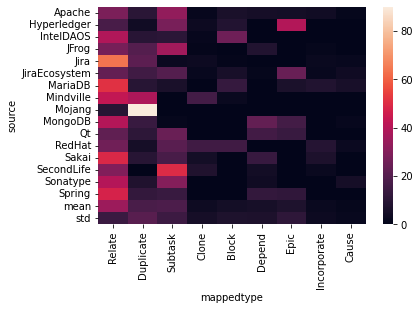

In [58]:
sns.heatmap(pivot_freq)

In [59]:
pivot_samep = pd.pivot_table(commontypes, values='sameproject', index=['source'],
                    columns=['mappedtype'], aggfunc=np.sum)

pivot_samep_new = pd.DataFrame()
pivot_samep_new = pivot_samep[common_lt_set]

pivot_samep_new.fillna(0, inplace = True)

pivot_samep_new

mappedtype,Relate,Duplicate,Subtask,Clone,Block,Depend,Epic,Incorporate,Cause
source,,,,,,,,,
Apache,90.54,97.47,99.96,96.97,87.65,85.49,99.90,95.53,91.85
Hyperledger,88.60,93.42,100.00,89.73,88.17,0.00,97.20,0.00,0.00
IntelDAOS,95.79,94.44,100.00,100.00,96.39,0.00,0.00,0.00,0.00
JFrog,88.24,99.07,100.00,96.30,0.00,53.52,0.00,97.73,0.00
Jira,36.41,94.33,100.00,71.39,84.80,95.76,0.00,97.14,79.65
JiraEcosystem,90.51,94.72,100.00,86.57,76.55,87.40,96.78,90.69,79.09
MariaDB,96.99,99.34,100.00,0.00,95.42,0.00,99.89,98.44,96.44
Mindville,100.00,100.00,0.00,71.43,100.00,0.00,0.00,0.00,0.00
Mojang,96.40,94.36,0.00,98.15,99.16,0.00,0.00,0.00,0.00


In [60]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [73]:
import numpy as np
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine
from numpy import dot
from numpy.linalg import norm

A = pivot_new.to_numpy()
# B = pivot_samep_new.to_numpy()
# C = overview[['#Links', '#Linktypes', '%IssuesWithLinks', '#Projects']].to_numpy()
# D = np.hstack((A,B))
# E = np.hstack((D,C))
# F = np.hstack((A,C))

<AxesSubplot:>

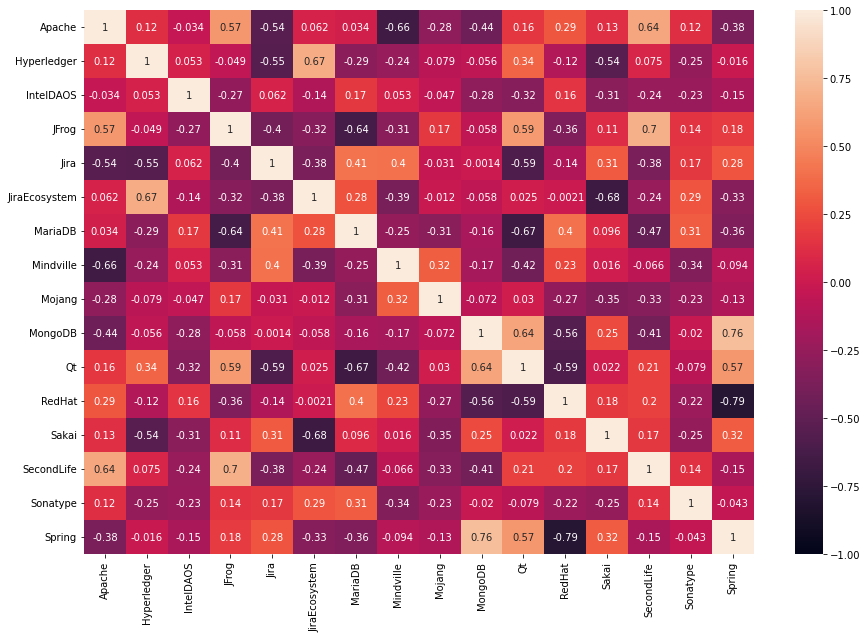

In [74]:
plt.figure(figsize=(15,10))
a = StandardScaler().fit_transform(A)
dist_out = 1-pairwise_distances(a, metric="cosine")
sns.heatmap(pd.DataFrame(dist_out, columns=SOURCES, index=SOURCES), annot = True, vmin = -1, vmax = 1)

<AxesSubplot:>

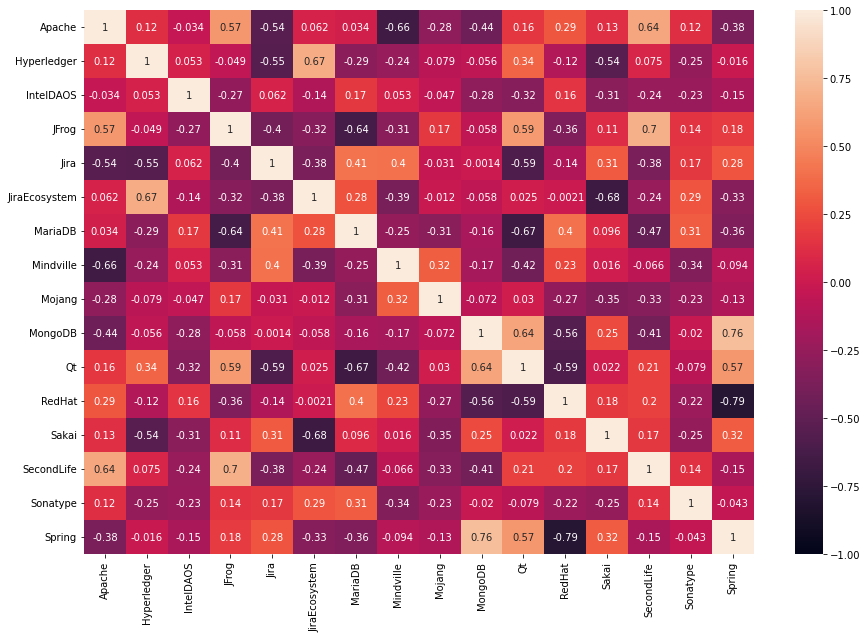

In [75]:
plt.figure(figsize=(15,10))
sns.heatmap(pd.DataFrame(cosine_similarity(a), columns=SOURCES, index=SOURCES), annot = True, vmin = -1, vmax = 1)

In [76]:
from sklearn.cluster import KMeans

kmeans_kwargs = {"init": "random", "n_init": 10, "max_iter": 300, "random_state": 42}
sse = []
for k in range(2, 16):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(A)
    sse.append(kmeans.inertia_)

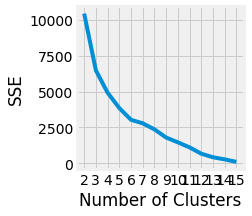

In [77]:
fig = plt.figure(figsize = (3,3))
plt.style.use("fivethirtyeight")
plt.plot(range(2, 16), sse)
plt.xticks(range(2, 16))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [78]:
from kneed import KneeLocator
kl = KneeLocator(range(2, 16), sse, curve="convex", direction="decreasing")
knee = kl.elbow
print(knee)

6


In [79]:
means = KMeans(init="random", 
                n_clusters=knee, 
                n_init=10, 
                max_iter=300, 
                random_state=9)
label = means.fit_predict(A)

In [80]:
overview['cluster_A'] = label

In [81]:
for i in range(knee):
    print("---------" +str(i)+ "---------")
    print(overview[overview['cluster_A']==i]['Project'])

---------0---------
13    SecondLife
Name: Project, dtype: object
---------1---------
1      Hyperledger
5    JiraEcosystem
Name: Project, dtype: object
---------2---------
2     IntelDAOS
6       MariaDB
9       MongoDB
12        Sakai
15       Spring
Name: Project, dtype: object
---------3---------
0       Apache
3        JFrog
10          Qt
11      RedHat
14    Sonatype
Name: Project, dtype: object
---------4---------
4         Jira
7    Mindville
Name: Project, dtype: object
---------5---------
8    Mojang
Name: Project, dtype: object


In [122]:
pivot_new[pivot_new.index.isin(overview[overview['cluster_A']==4]['Project'])]

mappedtype,Relate,Duplicate,Subtask,Clone,Block,Depend,Split,Incorporate,Epic
source,,,,,,,,,
Jira,63.762410,21.724321,2.477484,2.871197,0.988790,0.165299,0.181328,2.453441,0.0
Mindville,43.181818,38.636364,0.000000,15.909091,2.272727,0.000000,0.000000,0.000000,0.0


In [78]:
a

array([[-3.37521595e-01, -3.36807567e-01,  1.00122523e+00,
        -3.98227921e-01,  1.44530171e-02, -3.24602290e-01,
         5.14599831e-01, -3.64466915e-01,  6.41399108e-01,
        -3.00787987e-01, -1.85762236e-01],
       [-1.08857330e+00, -6.41394827e-01,  6.63078100e-01,
        -1.52247528e-01, -8.24096822e-01,  1.63758628e+00,
         9.46110605e-01, -6.57411240e-02, -7.45841297e-01,
        -2.79021301e-01, -7.11802678e-01],
       [-1.41676991e+00, -6.54680498e-01, -8.48381223e-01,
         1.65051961e-01, -8.24096822e-01,  3.10883095e+00,
         5.93726835e-01, -3.64466915e-01, -7.45841297e-01,
        -3.01211623e-01, -7.11802678e-01],
       [-4.23251460e-01,  1.29195691e-01,  1.26512870e+00,
        -6.04960804e-01,  4.53929375e-01, -6.03778795e-01,
        -7.50834833e-01, -3.64466915e-01, -2.96914160e-01,
        -3.01211623e-01, -7.11802678e-01],
       [ 1.99358134e+00,  2.17068589e-01, -1.07829180e+00,
        -1.80267218e-01, -8.15777900e-01, -6.03778795e-01,
  

<AxesSubplot:>

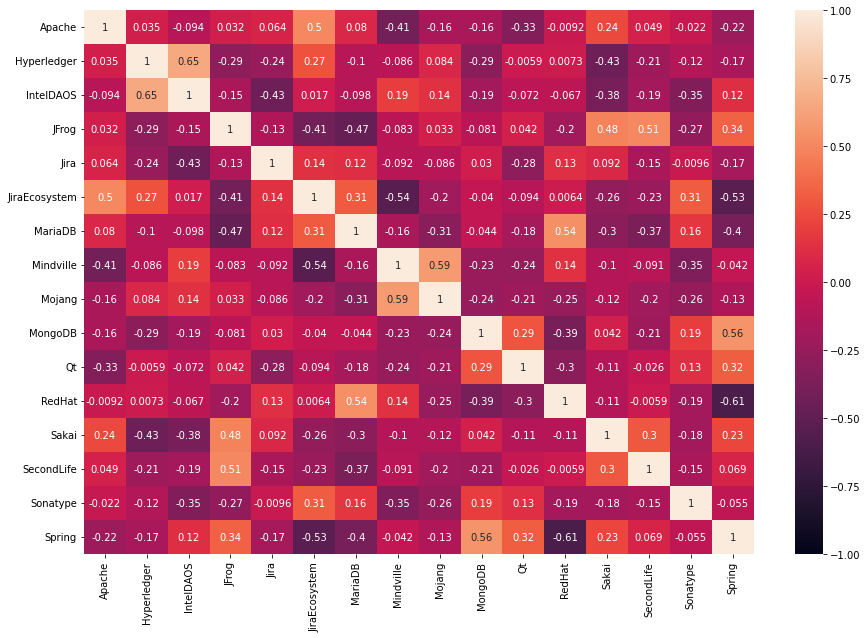

In [26]:
plt.figure(figsize=(15,10))
d = StandardScaler().fit_transform(D)
dist_out_1 = 1-pairwise_distances(d, metric="cosine")
sns.heatmap(pd.DataFrame(dist_out_1, columns=SOURCES, index=SOURCES), annot = True, vmin = -1, vmax = 1)

<AxesSubplot:>

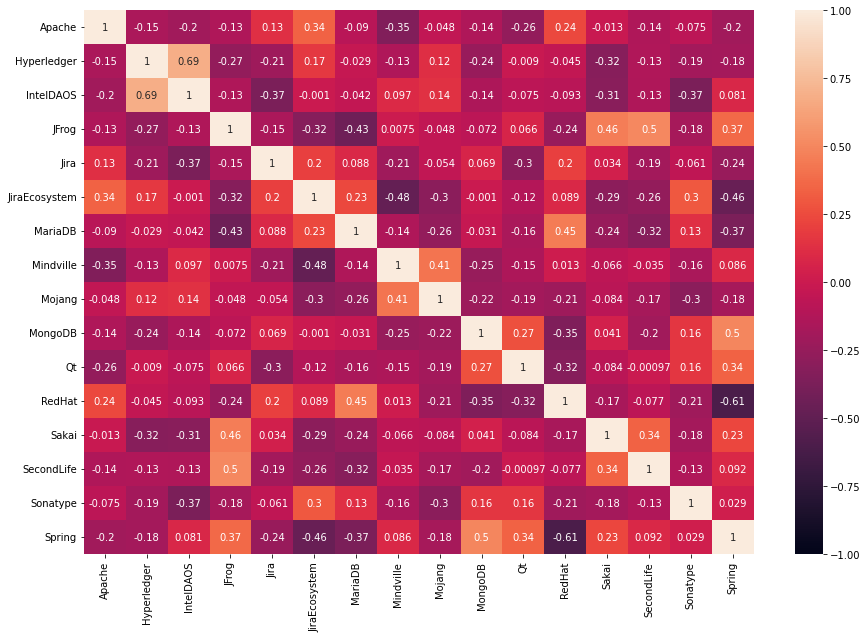

In [27]:
plt.figure(figsize=(15,10))
e = StandardScaler().fit_transform(E)
dist_out_2 = 1-pairwise_distances(e, metric="cosine")
sns.heatmap(pd.DataFrame(dist_out_2, columns=SOURCES, index=SOURCES), annot = True, vmin = -1, vmax = 1)

<AxesSubplot:>

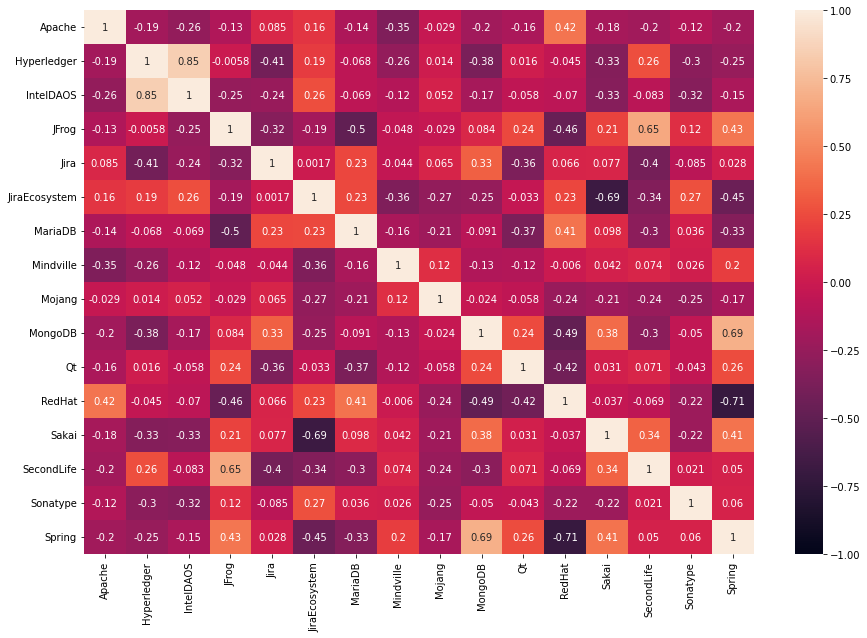

In [28]:
plt.figure(figsize=(15,10))
f = StandardScaler().fit_transform(F)
dist_out_3 = 1-pairwise_distances(f, metric="cosine")
sns.heatmap(pd.DataFrame(dist_out_3, columns=SOURCES, index=SOURCES), annot = True, vmin = -1, vmax = 1)

In [133]:
sns.set_style('whitegrid')

color_dict = {'Apache':'yellow',
  'Hyperledger':'dodgerblue',
  'IntelDAOS':'green',
  'JFrog':'yellow',
  'Jira':'red',
  'JiraEcosystem':'dodgerblue',
  'MariaDB':'green',
  'Mindville':'red',
  'Mojang':'black',
  'MongoDB':'green',
  'Qt':'yellow',
  'RedHat':'yellow',
  'Sakai':'green',
  'SecondLife':'dodgerblue',
  'Sonatype':'yellow',
  'Spring':'green'    
}

Text(0, 0.5, 'PC2')

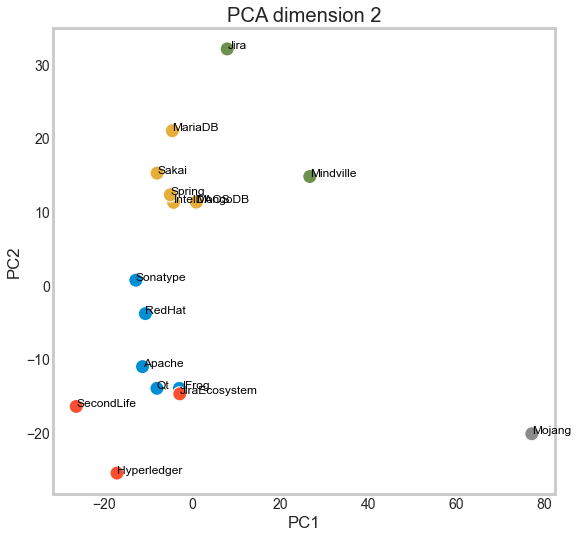

In [138]:
pca_2 = PCA(n_components=2)
principalComponents = pca_2.fit_transform(A)
df_pca_2 = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
repo = pd.DataFrame(pd.Series(SOURCES), columns=['repo'])
repo['color'] = repo['repo'].map(color_dict)

df_plot_pca_2 = pd.concat([df_pca_2, repo],axis = 1)

fig = plt.figure(figsize = (8,8))

p1 = sns.scatterplot(x='PC1', # Horizontal axis
       y='PC2', # Vertical axis
       data=df_plot_pca_2,
                     hue="color",# Data source
                     s = 200,
       legend=False)  

for line in range(0,df_plot_pca_2.shape[0]):
     p1.text(df_plot_pca_2.PC1[line]+0.0125, df_plot_pca_2.PC2[line], 
     df_plot_pca_2.repo[line], horizontalalignment='left', 
     size=12, color='black')
        

        
plt.grid()

plt.title("PCA dimension 2")
# Set x-axis label
# plt.xlabel('Accuracy')
plt.xlabel('PC1')
# Set y-axis label
plt.ylabel('PC2')


Text(0, 0.5, 'PC2')

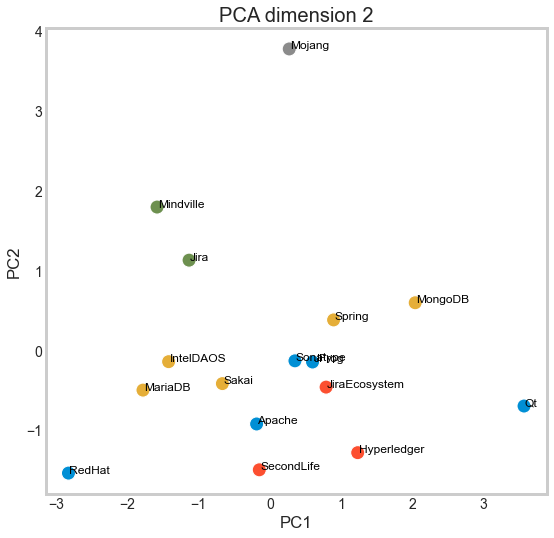

In [139]:
pca_2 = PCA(n_components=2)
principalComponents = pca_2.fit_transform(a)
df_pca_2 = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
repo = pd.DataFrame(pd.Series(SOURCES), columns=['repo'])
repo['color'] = repo['repo'].map(color_dict)

df_plot_pca_2 = pd.concat([df_pca_2, repo],axis = 1)

fig = plt.figure(figsize = (8,8))

p1 = sns.scatterplot(x='PC1', # Horizontal axis
       y='PC2', # Vertical axis
       data=df_plot_pca_2,
                     hue="color",# Data source
                     s = 200,
       legend=False)  

for line in range(0,df_plot_pca_2.shape[0]):
     p1.text(df_plot_pca_2.PC1[line]+0.0125, df_plot_pca_2.PC2[line], 
     df_plot_pca_2.repo[line], horizontalalignment='left', 
     size=12, color='black')
        

        
plt.grid()

plt.title("PCA dimension 2")
# Set x-axis label
# plt.xlabel('Accuracy')
plt.xlabel('PC1')
# Set y-axis label
plt.ylabel('PC2')


/export/home/lueders/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'PC2')

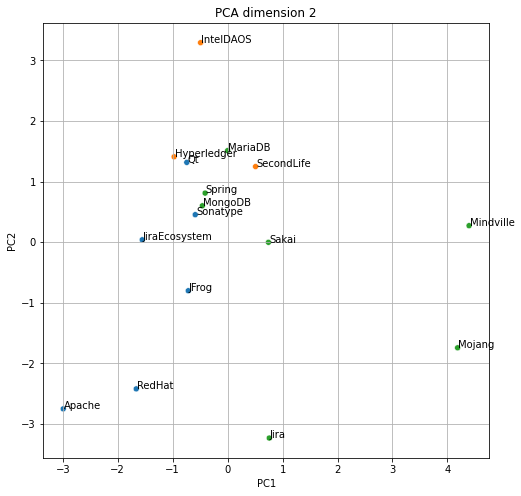

In [183]:
pca_2 = PCA(n_components=2)
principalComponents = pca_2.fit_transform(e)
df_pca_2 = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
repo = pd.DataFrame(pd.Series(SOURCES), columns=['repo'])
repo['color'] = repo['repo'].map(color_dict)

df_plot_pca_2 = pd.concat([df_pca_2, repo],axis = 1)

fig = plt.figure(figsize = (8,8))

p1 = sns.scatterplot('PC1', # Horizontal axis
       'PC2', # Vertical axis
       data=df_plot_pca_2,
                     hue="color",# Data source
       legend=False)  


for line in range(0,df_plot_pca_2.shape[0]):
     p1.text(df_plot_pca_2.PC1[line]+0.0125, df_plot_pca_2.PC2[line], 
     df_plot_pca_2.repo[line], horizontalalignment='left', 
     size=10, color='black')
        
plt.grid()

plt.title("PCA dimension 2")
# Set x-axis label
# plt.xlabel('Accuracy')
plt.xlabel('PC1')
# Set y-axis label
plt.ylabel('PC2')


/export/home/lueders/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'PC2')

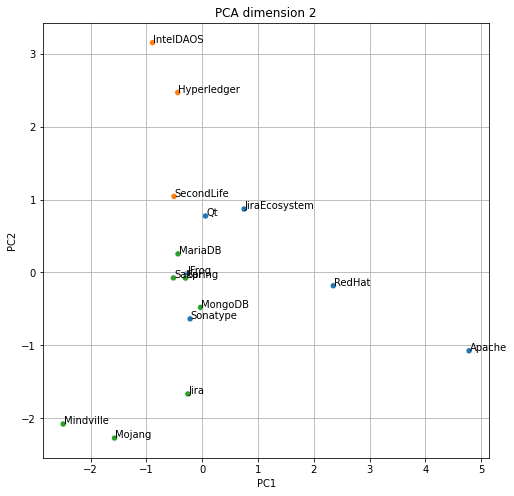

In [184]:
pca_2 = PCA(n_components=2)
principalComponents = pca_2.fit_transform(f)
df_pca_2 = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
repo = pd.DataFrame(pd.Series(SOURCES), columns=['repo'])
repo['color'] = repo['repo'].map(color_dict)

df_plot_pca_2 = pd.concat([df_pca_2, repo],axis = 1)

fig = plt.figure(figsize = (8,8))

p1 = sns.scatterplot('PC1', # Horizontal axis
       'PC2', # Vertical axis
       data=df_plot_pca_2,
                     hue="color",# Data source
       legend=False)  

for line in range(0,df_plot_pca_2.shape[0]):
     p1.text(df_plot_pca_2.PC1[line]+0.0125, df_plot_pca_2.PC2[line], 
     df_plot_pca_2.repo[line], horizontalalignment='left', 
     size=10, color='black')
        
plt.grid()

plt.title("PCA dimension 2")
# Set x-axis label
# plt.xlabel('Accuracy')
plt.xlabel('PC1')
# Set y-axis label
plt.ylabel('PC2')


In [136]:
categories = ['General Relation', 'Duplication', 'Temporal/Causal', 'Composition', 'Workflow']
cat_short = [ 'Com.', 'Gen.', 'Dup.', 'T/C', 'Wor.']

In [137]:
cat_dict = {'Block': 'Causal',
    'Bonfire Testing': 'Workflow',
    'Breaks': 'Causal',
    'Cause': 'Causal',
    'Clone': 'General',
    'Depend': 'Causal',
    'Detail': 'Workflow',
    'Documented': 'Workflow',
    'Duplicate': 'General',
    'Epic': 'Epic',
    'Fix': 'Workflow',
    'Follow': 'Causal',
    'Incorporate': 'Split',
    'Parent-Child': 'Split',
    'Relate': 'General',
    'Replace': 'General',
    'Require': 'Causal',
    'Split': 'Split',
    'Subtask': 'Split',
    'Supercede': 'Causal',
    'Trigger': 'Workflow',
    'finish-start': 'Causal',
    'Non-Link': 'Non-Link'
           }

In [138]:
def print_cleaned_linktypes(SOURCE):  
    
    issues = issue_dict[SOURCE]
    links = link_dict[SOURCE]
    
    issue_set = set(issues.index.values)
    link_set = set(links['issue_id_1']).union(set(links['issue_id_2']))
    
    links['temp'] = links['linktype'].map(type_dict)
    links['mappedtype'] = links['temp'].map(cat_dict)
            
    projects = issues[['projectid', 'issue_id']]

    temp = links.merge(projects, left_on = 'issue_id_1', right_on='issue_id')
    temp = temp.merge(projects, left_on = 'issue_id_2', right_on='issue_id', suffixes=('_1', '_2'))

    temp['sameproject'] = (temp["projectid_1"]==temp["projectid_2"])

    blub = links.mappedtype.value_counts().rename_axis('mappedtype').reset_index(name='counts')
    blub['source'] = SOURCE
    blub['percentageOfLinks'] = blub['counts'].apply(lambda x: round(x/len(links),10)*100)
    blub['percentagesOfIssues'] = 0
    blub['sameproject'] = 0
    blub['crossproject'] = 0
    for i in range(len(blub)):
        mappedType = blub['mappedtype'].iloc[i]
        link_temp = temp[temp['mappedtype'] == mappedType]
        lt_set = set(link_temp['issue_id_1']).union(set(link_temp['issue_id_2']))
        blub['percentagesOfIssues'].iloc[i] = round(len(lt_set)/len(issue_set),10)*100
        
        try:
            same_ratio_temp = round(link_temp['sameproject'].value_counts().loc[True]/len(link_temp)*100, 2)
        except:
            same_ratio_temp = 0
        try:
            cross_ratio_temp = round(link_temp['sameproject'].value_counts().loc[False]/len(link_temp)*100, 2)
        except:
            cross_ratio_temp = 0
            
        blub['sameproject'].iloc[i] = same_ratio_temp
        blub['crossproject'].iloc[i] = cross_ratio_temp
        
    return len(links.mappedtype.unique()), blub

In [139]:
overview_cl = pd.DataFrame(columns=['Source', '#Linktypes'])
link_dist_cl = pd.DataFrame(columns=['source', 'mappedtype', 'counts'])
j = 0
for s in SOURCES:
    ltu, blub = print_cleaned_linktypes(s)
    overview_cl.loc[j] = [s, ltu]
    
    j+=1
    
    frames = [link_dist_cl, blub]
    #concatenate dataframes
    link_dist_cl = pd.concat(frames, sort=False)

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [140]:
common_lt = (link_dist_cl.mappedtype.value_counts()>=3).rename_axis('mappedtype').reset_index(name='valid')
common_lt_set = common_lt[common_lt['valid']==True]['mappedtype'].values
commontypes = link_dist_cl[link_dist_cl['mappedtype'].isin(common_lt_set)]
commontypes.groupby(['mappedtype']).agg({'counts': ['sum'], 'percentageOfLinks': ['mean'], 'sameproject': ['mean'], 'crossproject': ['mean']})

,counts,percentageOfLinks,sameproject,crossproject
,sum,mean,mean,mean
mappedtype,,,,
Causal,93160,11.277798,87.749375,12.250625
Epic,32766,19.005375,98.704444,1.295556
General,532027,55.018149,90.022500,9.977500
Split,158147,24.355446,98.862143,1.137857
Workflow,5882,2.518460,82.876000,17.124000


In [141]:
#easier to copy for Latex
pivot = pd.pivot_table(commontypes, values='percentageOfLinks', index=['source'],
                    columns=['mappedtype'], aggfunc=np.sum)
pivot_new = pd.DataFrame()
pivot_new = pivot[common_lt_set]

pivot_new.fillna(0, inplace = True)

pivot_new

mappedtype,Causal,General,Split,Workflow,Epic
source,,,,,
Apache,16.904906,40.438509,37.493153,0.220325,4.943107
Hyperledger,8.265023,23.932203,28.073960,0.043143,39.685670
IntelDAOS,7.666046,20.266915,5.803849,0.000000,65.735568
JFrog,8.078603,47.785402,37.648160,6.300686,0.000000
Jira,3.693361,88.470476,5.143597,2.177901,0.000000
JiraEcosystem,11.529649,40.821190,23.407570,0.907341,23.270094
MariaDB,18.956082,60.459707,14.140101,0.000000,6.444110
Mindville,2.272727,97.727273,0.000000,0.000000,0.000000
Mojang,0.110891,99.762907,0.000000,0.126202,0.000000


In [142]:
pivot_samep = pd.pivot_table(commontypes, values='sameproject', index=['source'],
                    columns=['mappedtype'], aggfunc=np.sum)

pivot_samep_new = pd.DataFrame()
pivot_samep_new = pivot_samep[common_lt_set]

pivot_samep_new.fillna(0, inplace = True)

pivot_samep_new

mappedtype,Causal,General,Split,Workflow,Epic
source,,,,,
Apache,87.90,92.52,99.40,95.33,99.89
Hyperledger,88.14,89.44,99.93,100.00,97.24
IntelDAOS,100.00,100.00,100.00,0.00,100.00
JFrog,53.67,92.89,99.92,83.17,0.00
Jira,83.72,51.36,98.22,97.15,0.00
JiraEcosystem,79.57,92.03,98.79,92.93,96.61
MariaDB,95.74,97.35,99.13,0.00,99.89
Mindville,100.00,95.35,0.00,0.00,0.00
Mojang,99.16,94.56,0.00,99.26,0.00


In [143]:
import numpy as np
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine
from numpy import dot
from numpy.linalg import norm


A = pivot_new.to_numpy()
B = pivot_samep_new.to_numpy()
C = overview[['#Links', '#Linktypes', '%IssuesWithLinks', '#Projects']].to_numpy()
D = np.hstack((A,B))
E = np.hstack((D,C))
F = np.hstack((A,C))

<AxesSubplot:>

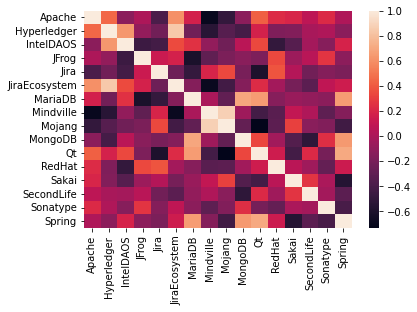

In [144]:
d = StandardScaler().fit_transform(D)
dist_out_1 = 1-pairwise_distances(d, metric="cosine")
sns.heatmap(pd.DataFrame(dist_out_1, columns=SOURCES, index=SOURCES))

<AxesSubplot:>

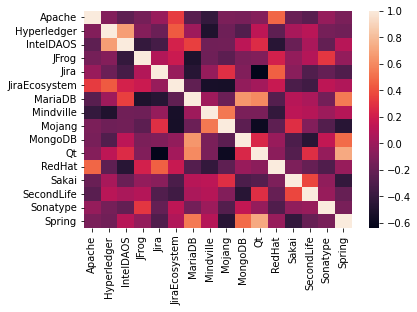

In [145]:
e = StandardScaler().fit_transform(E)
dist_out_2 = 1-pairwise_distances(e, metric="cosine")
sns.heatmap(pd.DataFrame(dist_out_2, columns=SOURCES, index=SOURCES))

<AxesSubplot:>

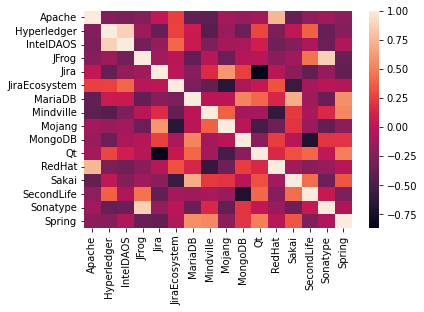

In [146]:
f = StandardScaler().fit_transform(F)
dist_out_3 = 1-pairwise_distances(f, metric="cosine")
sns.heatmap(pd.DataFrame(dist_out_3, columns=SOURCES, index=SOURCES))

/export/home/lueders/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'PC2')

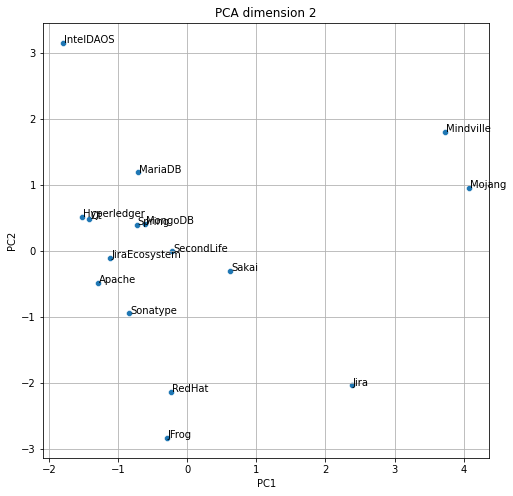

In [147]:
pca_2 = PCA(n_components=2)
principalComponents = pca_2.fit_transform(d)
df_pca_2 = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
df_plot_pca_2 = pd.concat([df_pca_2, pd.Series(SOURCES, name='repo')],axis = 1)

fig = plt.figure(figsize = (8,8))

p1 = sns.scatterplot('PC1', # Horizontal axis
       'PC2', # Vertical axis
       data=df_plot_pca_2, # Data source
       legend=False)  

for line in range(0,df_plot_pca_2.shape[0]):
     p1.text(df_plot_pca_2.PC1[line]+0.0125, df_plot_pca_2.PC2[line], 
     df_plot_pca_2.repo[line], horizontalalignment='left', 
     size=10, color='black')
        
plt.grid()

plt.title("PCA dimension 2")
# Set x-axis label
# plt.xlabel('Accuracy')
plt.xlabel('PC1')
# Set y-axis label
plt.ylabel('PC2')


/export/home/lueders/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'PC2')

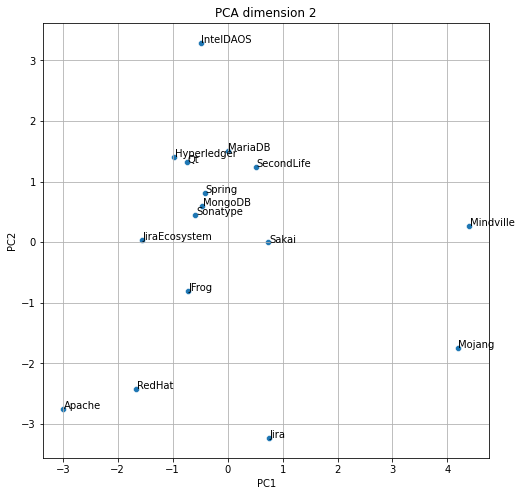

In [148]:
pca_2 = PCA(n_components=2)
principalComponents = pca_2.fit_transform(e)
df_pca_2 = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
df_plot_pca_2 = pd.concat([df_pca_2, pd.Series(SOURCES, name='repo')],axis = 1)

fig = plt.figure(figsize = (8,8))

p1 = sns.scatterplot('PC1', # Horizontal axis
       'PC2', # Vertical axis
       data=df_plot_pca_2, # Data source
       legend=False)  

for line in range(0,df_plot_pca_2.shape[0]):
     p1.text(df_plot_pca_2.PC1[line]+0.0125, df_plot_pca_2.PC2[line], 
     df_plot_pca_2.repo[line], horizontalalignment='left', 
     size=10, color='black')
        
plt.grid()

plt.title("PCA dimension 2")
# Set x-axis label
# plt.xlabel('Accuracy')
plt.xlabel('PC1')
# Set y-axis label
plt.ylabel('PC2')


/export/home/lueders/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'PC2')

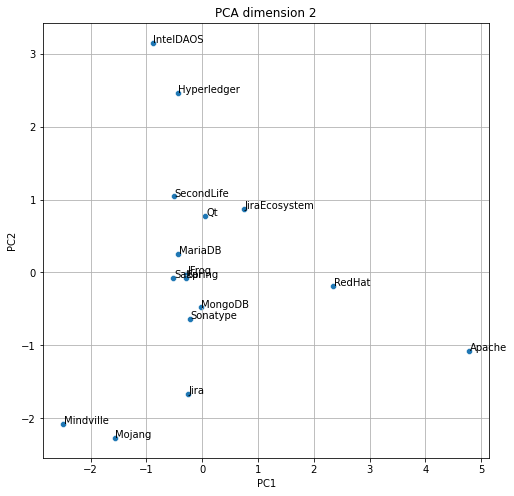

In [149]:
pca_2 = PCA(n_components=2)
principalComponents = pca_2.fit_transform(f)
df_pca_2 = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
df_plot_pca_2 = pd.concat([df_pca_2, pd.Series(SOURCES, name='repo')],axis = 1)

fig = plt.figure(figsize = (8,8))

p1 = sns.scatterplot('PC1', # Horizontal axis
       'PC2', # Vertical axis
       data=df_plot_pca_2, # Data source
       legend=False)  

for line in range(0,df_plot_pca_2.shape[0]):
     p1.text(df_plot_pca_2.PC1[line]+0.0125, df_plot_pca_2.PC2[line], 
     df_plot_pca_2.repo[line], horizontalalignment='left', 
     size=10, color='black')
        
plt.grid()

plt.title("PCA dimension 2")
# Set x-axis label
# plt.xlabel('Accuracy')
plt.xlabel('PC1')
# Set y-axis label
plt.ylabel('PC2')


In [55]:
apa = (259717-256253)/263647
hyp = (16565-16325)/16733
inte = (2641-2605)/2667
jfr = (3273-3233)/3303
jir = (101180-100096)/102573
jie = (11514-11414)/11598
mar = (14773-14659)/14929
mind = (44-44)/46
moj = (215658-215542)/215802
mon = (64537-63883)/65240
qt = (40424-40128)/40646
red = (121612-120136)/123000
sak = (20040-19852)/20292
sec = (662-634)/674
son = (4498-4466)/4534
spr = (14550-14478)/14616

In [69]:
(apa + hyp + inte + jfr + jir + jie + mar + mind + moj + mon + qt + red + sak + sec + son + spr)/16

0.010784544654789006

In [74]:
spr

0.0049261083743842365